In [1]:
import pandas as pd
import swifter
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import DiceSimilarity, TanimotoSimilarity

RADIUS = 3
N_BITS = 2048
FP_GEN = AllChem.GetMorganGenerator(fpSize=N_BITS, radius=RADIUS)

def get_fingerprint(smiles_string, fpgen=FP_GEN):
    mol = Chem.MolFromSmiles(smiles_string)

    if not mol:
        return None

    fp = fpgen.GetSparseCountFingerprint(mol)
    return fp

def get_inchi(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Chem.MolToInchi(mol)

def get_most_similar_fp(input_fp, ref_df):
    similarity = 0
    smiles_out = None
    for fp, smiles in zip(ref_df.fp.values, ref_df.SMILES.values):
        s = TanimotoSimilarity(input_fp, fp)
        if s > similarity:
            similarity = s
            smiles_out = smiles
    return similarity, smiles_out

In [2]:
df_test = pd.read_csv("./data/SMILES_test/test_data_all.csv")
df_test["fp"] = df_test.SMILES.swifter.apply(get_fingerprint)
df_train = pd.concat(
    [
    pd.read_csv("./data/SMILES_training/trainingset_covalent_smiles.csv"),
    pd.read_csv("./data/SMILES_training/trainingset_noncovalent_smiles.csv")
    ])
df_train["fp"] = df_train.SMILES.swifter.apply(get_fingerprint)

Pandas Apply:   0%|          | 0/610 [00:00<?, ?it/s]

/Users/vh/InstalledPackages/miniconda3/envs/molgraph/lib/python3.10/site-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/52207 [00:00<?, ?it/s]

In [3]:
df_test["most_similar_smiles"] = df_test.fp.swifter.apply(lambda x:
    get_most_similar_fp(x, ref_df=df_train)[1])
df_test["tanimoto"] = df_test.fp.swifter.apply(lambda x:
    get_most_similar_fp(x, ref_df=df_train)[0])

Pandas Apply:   0%|          | 0/610 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/610 [00:00<?, ?it/s]

<Axes: >

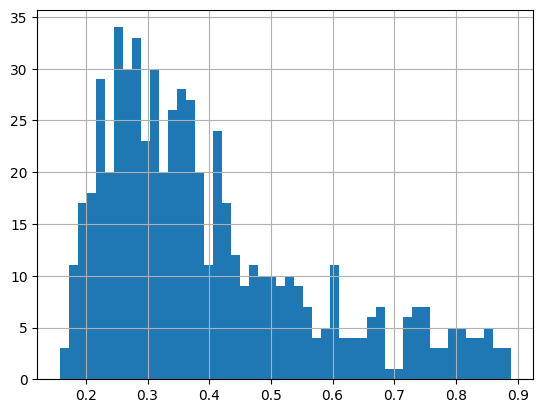

In [5]:
df_test.tanimoto.hist(bins=50)

In [10]:
(
    df_test.tanimoto.std(),
    df_test.tanimoto.mean(),
    df_test.tanimoto.median(),
)

(0.17230081715773718, 0.400034991429632, 0.35339366515837106)

In [ ]:
df = df_test.sort_values(by="tanimoto", ascending=False).reset_index(drop=True)

In [ ]:
Chem.MolFromSmiles(df.SMILES[1])

In [ ]:
Chem.MolFromSmiles(df.most_similar_smiles[1])